In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import LeNet5
from visualize import *
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")
# disentangled vae
sys.path.append('../disentangling-vae')
from collections import defaultdict
import vae_trim, vae_trim_viz
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import get_loss_f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from disvae import init_specific_model
from utils.datasets import get_img_size

### VAE-Attr-Pen-1

In [36]:
args = vae_trim.parse_arguments()
args.loss = "VAE"
args.reg_anneal = 0
args.attr_lamb = 1 # change of attribute wrt other attributes
# name = args.loss + "_B_" + str(args.btcvae_B) + "_attr_" + str(args.attr_lamb)
name = args.loss + "_attr_" + str(args.attr_lamb)
args.name = name

In [37]:
# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.eval_batchsize, device)

# initialize model
args.img_size = get_img_size(args.dataset)
model = init_specific_model(args.model_type, args.img_size, args.latent_dim).to(device)

# Train
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# loss
L1Loss = torch.nn.L1Loss()
loss_f = get_loss_f(args.loss,
                    n_data=len(train_loader.dataset),
                    device=device,
                    **vars(args))

m = DecoderEncoder(model)

Train model

In [38]:
model.train()
for epoch in range(5):
    epoch_loss = 0
    epoch_reg = 0
    # one epoch
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)    
        batch_size, channel, height, width = inputs.size()
        recon_batch, latent_dist, latent_sample = model(inputs)

        loss = loss_f(inputs, recon_batch, latent_dist, model.training,
                           None, latent_sample=latent_sample)        
        # penalize change in one attribute wrt the other attributes
        if args.attr_lamb > 0:
            s = deepcopy(latent_dist[0].detach())
            s = s.requires_grad_(True)
            s_output = m(s)
            attr_reg = 0
            for i in range(model.latent_dim):
                col_idx = np.arange(model.latent_dim)!=i
                gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                                retain_graph=True, create_graph=True, only_inputs=True)[0]
                gradient_pairwise = gradients[:,col_idx]
                attr_reg += args.attr_lamb * L1Loss(gradient_pairwise, torch.zeros_like(gradient_pairwise))
        loss += attr_reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        epoch_loss += loss.item()
        epoch_reg += attr_reg.item()      
        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(labels), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), loss.data.item()), end='')        
    mean_epoch_loss = epoch_loss / len(train_loader)
    mean_epoch_reg = epoch_reg / len(train_loader)
    print('\nAverage loss: {} - Average reg: {}'.format(mean_epoch_loss, mean_epoch_reg))

Train Epoch: 0 [29984/60000 (100%)]	Loss: 158.294495
Average loss: 200.27238618895444 - Average reg: 0.9039921596137954
Train Epoch: 1 [29984/60000 (100%)]	Loss: 167.514496
Average loss: 162.65034253866688 - Average reg: 0.9991621267058448
Train Epoch: 2 [29984/60000 (100%)]	Loss: 160.389450
Average loss: 158.34996434518777 - Average reg: 0.9760078649912307
Train Epoch: 3 [29984/60000 (100%)]	Loss: 152.696457
Average loss: 155.9498725028943 - Average reg: 0.9629841467210734
Train Epoch: 4 [29984/60000 (100%)]	Loss: 142.821411
Average loss: 154.39593377347185 - Average reg: 0.9548810851345184


In [39]:
model.eval()
epoch_loss = 0
epoch_reg = 0
for batch_idx, (inputs, labels) in enumerate(train_loader):     
    inputs = inputs.to(device)
    labels = labels.to(device)    
    batch_size, channel, height, width = inputs.size()
    recon_batch, latent_dist, latent_sample = model(inputs)

    loss = loss_f(inputs, recon_batch, latent_dist, model.training,
                       None, latent_sample=latent_sample)          
    # penalize change in one attribute wrt the other attributes
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = m(s)
    attr_reg = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradient_pairwise = gradients[:,col_idx]
        attr_reg += L1Loss(gradient_pairwise, torch.zeros_like(gradient_pairwise))
    epoch_loss += loss.item()
    epoch_reg += attr_reg.item()  
print(epoch_loss/len(train_loader), epoch_reg/len(train_loader))

147.3707662879277 0.9546791959418925


### VAE-Attr-Pen-2

In [40]:
args = vae_trim.parse_arguments()
args.loss = "VAE"
args.reg_anneal = 0
args.attr_lamb = 100 # change of attribute wrt other attributes
# name = args.loss + "_B_" + str(args.btcvae_B) + "_attr_" + str(args.attr_lamb)
name = args.loss + "_attr_" + str(args.attr_lamb)
args.name = name

In [41]:
# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.eval_batchsize, device)

# initialize model
args.img_size = get_img_size(args.dataset)
model = init_specific_model(args.model_type, args.img_size, args.latent_dim).to(device)

# Train
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# loss
L1Loss = torch.nn.L1Loss()
loss_f = get_loss_f(args.loss,
                    n_data=len(train_loader.dataset),
                    device=device,
                    **vars(args))

m = DecoderEncoder(model)

Train model

In [42]:
model.train()
for epoch in range(5):
    epoch_loss = 0
    epoch_reg = 0
    # one epoch
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)    
        batch_size, channel, height, width = inputs.size()
        recon_batch, latent_dist, latent_sample = model(inputs)

        loss = loss_f(inputs, recon_batch, latent_dist, model.training,
                           None, latent_sample=latent_sample)        
        # penalize change in one attribute wrt the other attributes
        if args.attr_lamb > 0:
            s = deepcopy(latent_dist[0].detach())
            s = s.requires_grad_(True)
            s_output = m(s)
            attr_reg = 0
            for i in range(model.latent_dim):
                col_idx = np.arange(model.latent_dim)!=i
                gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                                retain_graph=True, create_graph=True, only_inputs=True)[0]
                gradient_pairwise = gradients[:,col_idx]
                attr_reg += args.attr_lamb * L1Loss(gradient_pairwise, torch.zeros_like(gradient_pairwise))
        loss += attr_reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        epoch_loss += loss.item()
        epoch_reg += attr_reg.item()      
        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(labels), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), loss.data.item()), end='')        
    mean_epoch_loss = epoch_loss / len(train_loader)
    mean_epoch_reg = epoch_reg / len(train_loader)
    print('\nAverage loss: {} - Average reg: {}'.format(mean_epoch_loss, mean_epoch_reg))

Train Epoch: 0 [29984/60000 (100%)]	Loss: 210.608841
Average loss: 239.94518593989454 - Average reg: 10.854900648853164
Train Epoch: 1 [29984/60000 (100%)]	Loss: 196.884308
Average loss: 201.20241733705566 - Average reg: 7.1664520896065715
Train Epoch: 2 [29984/60000 (100%)]	Loss: 199.069855
Average loss: 194.75057225339194 - Average reg: 6.270021577887952
Train Epoch: 3 [29984/60000 (100%)]	Loss: 181.511642
Average loss: 190.6632037294953 - Average reg: 5.664612972914283
Train Epoch: 4 [29984/60000 (100%)]	Loss: 192.748352
Average loss: 187.72429473161188 - Average reg: 5.033098313600015


In [43]:
model.eval()
epoch_loss = 0
epoch_reg = 0
for batch_idx, (inputs, labels) in enumerate(train_loader):     
    inputs = inputs.to(device)
    labels = labels.to(device)    
    batch_size, channel, height, width = inputs.size()
    recon_batch, latent_dist, latent_sample = model(inputs)

    loss = loss_f(inputs, recon_batch, latent_dist, model.training,
                       None, latent_sample=latent_sample)          
    # penalize change in one attribute wrt the other attributes
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = m(s)
    attr_reg = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradient_pairwise = gradients[:,col_idx]
        attr_reg += L1Loss(gradient_pairwise, torch.zeros_like(gradient_pairwise))
    epoch_loss += loss.item()
    epoch_reg += attr_reg.item()  
print(epoch_loss/len(train_loader), epoch_reg/len(train_loader))

214.76879495649194 0.04623346317059068


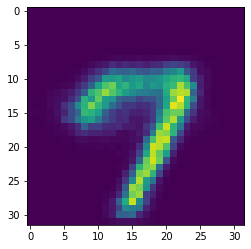

In [44]:
plt.imshow(recon_batch[0,0].detach().cpu().numpy())

In [ ]:
plt.imshow(recon_batch[0,0].detach().cpu().numpy())